In [44]:
suppressMessages(library(data.table))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(Cairo))

In [2]:
test_expr <- fread('/data/cellardata/users/jlz014/TCGA/expression/TCGA-BRCA.ENSG.chr1-22.median-filt.log2RPKM.qnorm.test.txt')
predicted_files <- Sys.glob('/cellar/users/jlz014/fusion_twas-master/TCGA-BRCA_normed_weights/prediction_results/*')
predicted_genes <- fread('predicted_genes_ordered.txt',header=F)$V1
predicted_genes_files <- fread('predicted_genes_ordered_files.txt',header=F)$V1

In [33]:
WD <- '/cellar/users/jlz014/fusion_twas-master/TCGA-BRCA_normed_weights'
file.path(WD, 'predicted_genes_ordered.txt')

[1] "/cellar/users/jlz014/fusion_twas-master/TCGA-BRCA_normed_weights/predicted_genes_ordered.txt"

# Generate subset of expression data matching order of genes in predicted_genes_ordered.txt

In [4]:
# filtered_expr <- filter(test_expr, gene %in% predicted_genes)
# head(filtered_expr[match(predicted_genes, filtered_expr$gene),])
# write.table(filtered_expr, 'filtered_test_expr_matched_to_predicted_genes.txt',sep='\t', col.names=T, row.names=F, quote=F)

In [32]:
filtered_expr <- fread('filtered_test_expr_matched_to_predicted_genes.txt')
head(filtered_expr)

gene,chr,start,end,TCGA-E9-A1NI,TCGA-E9-A22E,TCGA-AO-A0J6,TCGA-A7-A26F.22,TCGA-AO-A129,TCGA-E2-A14N,⋯,TCGA-AC-A2FM,TCGA-A8-A08C,TCGA-AQ-A1H3,TCGA-AO-A12A,TCGA-A7-A425,TCGA-E2-A14Q,TCGA-A7-A0DC.8,TCGA-C8-A12O,TCGA-AN-A0XR,TCGA-E2-A1LS.1
ENSG00000002016,12,1034628,1042224,0.21329002,-1.9592171,-2.1022991,-1.80142083,1.0131101,0.8455804,⋯,-1.6031076,0.5575240,-0.19391371,0.8487155,1.4324701,-1.6300696,1.6788269,-0.24325959,1.44895543,0.1450358
ENSG00000005471,7,87092176,87109751,0.60594021,1.9349257,-1.7656137,0.06940037,-0.7944949,-0.2065741,⋯,-1.5122900,-0.4144986,0.38681467,0.1998676,0.4667870,-0.8816153,-0.6758650,0.03796622,1.03780822,0.3077148
ENSG00000005801,11,3392209,3400384,0.02190008,-1.3372842,1.2855441,0.41927583,0.9255336,1.4084487,⋯,-1.5308729,-0.5037404,-0.66489865,0.8372606,-1.3337229,-0.1583269,2.0341785,-0.28559376,-0.06135378,-1.0478666
ENSG00000006282,17,48628094,48629300,0.15389357,-0.3161445,-0.1406113,-1.03905978,-2.3644934,-2.8721512,⋯,0.8320899,-0.2613450,0.08770561,-1.0747885,0.1325066,0.3844558,-0.4798505,0.53464612,-0.27648156,-0.3092458
ENSG00000006453,7,97984352,98029649,-1.06187258,-0.7706992,1.2625360,1.83182642,0.7186843,0.6164986,⋯,-0.1354527,0.2886364,-0.10383838,-0.5609380,-1.5285210,-0.5626474,-0.4137033,1.10385423,0.60594021,-2.2318316
ENSG00000006788,17,10204182,10276322,0.87946412,1.3058215,-1.4064833,1.01189140,0.1111801,-1.5238425,⋯,-0.7845260,-0.6147341,0.68414330,0.1288256,0.2530456,0.9210620,1.2449164,1.07869842,-0.39075091,-1.5031912


In [48]:
dim(filtered_expr)

[1] 1455  348

# Compute $R^2$

In [29]:
compute_rsq <- function(gene, true_values=filtered_expr, predicted_fh) {
    curr <- gene
    true <- filter(true_values, gene==curr)
    predicted <- fread(predicted_fh)
    sub_true <- true[which(colnames(true) %in% predicted$V1)]
    sub_true <- sub_true[match(predicted$V1,colnames(sub_true))]
    dat <- data.frame(observed=as.numeric(sub_observed[1,]), predicted=as.numeric(predicted$V2), row.names=colnames(sub_observed))
    return(summary(lm(observed~predicted,data=dat))$adj.r.squared)
}

In [38]:
rsq <- rep(NA, 5)
for (i in 1:5){
    gene <- predicted_genes[i]
    file <- predicted_genes_files[i]
    rsq[i] <- compute_rsq(gene, true_values=filtered_expr, predicted_fh=file)
}
rsq_df <- as.data.frame(rsq, row.names=predicted_genes[1:5])
rsq_df
write.table(rsq_df, 'tcga-brca_predictions_rsq.txt',quote=F, col.names=F, sep='\t')

,rsq
ENSG00000124549,-0.002341487
ENSG00000124143,-0.007069258
ENSG00000143552,-0.007046502
ENSG00000124688,-0.006249311
ENSG00000171853,0.012622027


# Test measure Rsq

In [6]:
curr_gene <- 'ENSG00000002016'

In [7]:
curr_target <- filter(filtered_expr, gene==curr_gene)
curr_target

gene,chr,start,end,TCGA-E9-A1NI,TCGA-E9-A22E,TCGA-AO-A0J6,TCGA-A7-A26F.22,TCGA-AO-A129,TCGA-E2-A14N,⋯,TCGA-AC-A2FM,TCGA-A8-A08C,TCGA-AQ-A1H3,TCGA-AO-A12A,TCGA-A7-A425,TCGA-E2-A14Q,TCGA-A7-A0DC.8,TCGA-C8-A12O,TCGA-AN-A0XR,TCGA-E2-A1LS.1
ENSG00000002016,12,1034628,1042224,0.21329,-1.959217,-2.102299,-1.801421,1.01311,0.8455804,⋯,-1.603108,0.557524,-0.1939137,0.8487155,1.43247,-1.63007,1.678827,-0.2432596,1.448955,0.1450358


In [16]:
predicted <- fread('prediction_results/ENSG00000002016.predictions.txt')

In [17]:
head(predicted)

V1,V2
TCGA-A1-A0SG,-0.15118534
TCGA-A2-A04N,0.01393538
TCGA-A2-A0D1,-0.06439425
TCGA-A2-A0D2,0.00000000
TCGA-A2-A0EM,-0.10744758
TCGA-A2-A0ES,0.00000000


In [10]:
sub_observed <- curr_target[which(colnames(curr_target) %in% predicted$V1)]

In [11]:
sub_observed <- sub_observed[match(predicted$V1,colnames(sub_observed))]
sub_observed

TCGA-A1-A0SG,TCGA-A2-A04N,TCGA-A2-A0D1,TCGA-A2-A0D2,TCGA-A2-A0EM,TCGA-A2-A0ES,TCGA-A2-A0EX,TCGA-A2-A0YD,TCGA-A2-A0YH,TCGA-A2-A0YJ,⋯,TCGA-E9-A249,TCGA-EW-A1PG,TCGA-EW-A2FV,TCGA-GI-A2C8,TCGA-GM-A2DN,TCGA-GM-A3NW,TCGA-GM-A3XG,TCGA-GM-A3XN,TCGA-LD-A7W6,TCGA-Z7-A8R6
-0.5798337,0.6740316,0.8581713,-0.8848498,-0.8055526,-0.2817942,-2.000669,-0.4336658,0.09210302,-0.6630787,⋯,1.188309,-0.8372606,-0.8351896,-0.8116258,-0.4449202,0.4065573,-0.2901587,0.2492789,1.474448,0.4864129


In [12]:
dat <- data.frame(observed=as.numeric(sub_observed[1,]), predicted=as.numeric(predicted$V2), row.names=colnames(sub_observed))
head(dat)

,observed,predicted
TCGA-A1-A0SG,-0.5798337,-0.15118534
TCGA-A2-A04N,0.6740316,0.01393538
TCGA-A2-A0D1,0.8581713,-0.06439425
TCGA-A2-A0D2,-0.8848498,0.00000000
TCGA-A2-A0EM,-0.8055526,-0.10744758
TCGA-A2-A0ES,-0.2817942,0.00000000


In [14]:
summary(lm(observed~predicted,data=dat))$adj.r.squared

[1] 0.02788193

# Plot $R^2$

In [42]:
rsq <- fread('tcga-brca_predictions_rsq.txt')
colnames(rsq) <- c('gene','rsq')
head(rsq)

gene,rsq
ENSG00000124549,0.028241679
ENSG00000124143,-0.006335525
ENSG00000143552,0.045258769
ENSG00000124688,-0.006504400
ENSG00000171853,0.069118046
ENSG00000125551,0.027063066


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


png 
  2

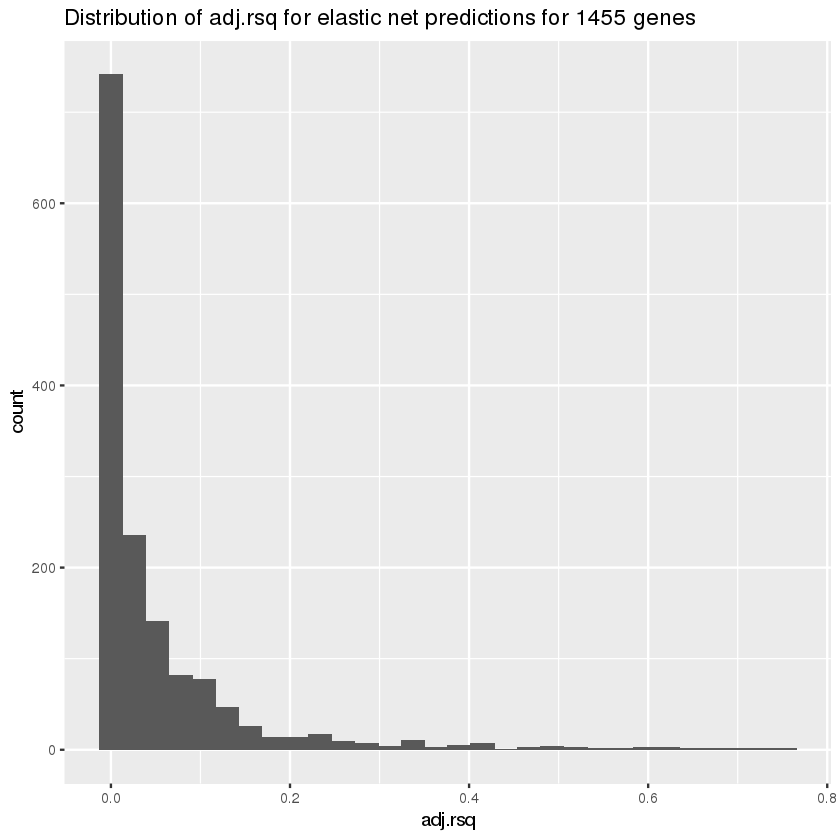

In [47]:
CairoPNG(width=640, height=480, file='tcga-brca_enet_adj_rsq_distribution.png')
ggplot(data=rsq, aes(rsq)) + geom_histogram() + labs(x='adj.rsq', title='Distribution of adj.rsq for elastic net predictions for 1455 genes')
dev.off()